In [2]:
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from openbb import obb

In [3]:


# Set the URLs to Edgar's data repository
SEC_URL = "https://www.sec.gov/"
FSN_PATH = "files/dera/data/financial-statement-and-notes-data-sets/"
DATA_PATH = Path("edgar")
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36"

In [4]:
filing_periods = [
    (d.year, d.quarter) for d in pd.date_range("2015", "2015-12-31", freq="QE")
]

for yr, qtr in tqdm(filing_periods):
    path = DATA_PATH / f"{yr}_{qtr}" / "source"
    if not path.exists():
        path.mkdir(parents=True)
    filing = f"{yr}q{qtr}_notes.zip"
    url = f"{SEC_URL}{FSN_PATH}{filing}"
    response = requests.get(url, headers={"User-Agent": user_agent}).content
    with ZipFile(BytesIO(response)) as zip_file:
        for file in zip_file.namelist():
            local_file = path / file
            if local_file.exists():
                continue
            with local_file.open("wb") as output:
                for line in zip_file.open(file).readlines():
                    output.write(line)

100%|██████████| 4/4 [02:21<00:00, 35.44s/it]


In [5]:
for f in tqdm(sorted(list(DATA_PATH.glob("**/*.tsv")))):
    parquet_path = f.parent.parent / "parquet"
    if not parquet_path.exists():
        parquet_path.mkdir(parents=True)
    file_name = f.stem + ".parquet"
    if not (parquet_path / file_name).exists():
        df = pd.read_csv(
            f, sep="\t", encoding="latin1", low_memory=False, on_bad_lines="skip"
        )
        df.to_parquet(parquet_path / file_name)
        f.unlink()

100%|██████████| 32/32 [01:38<00:00,  3.09s/it]


In [6]:
sub = pd.read_parquet(DATA_PATH / '2015_3' / 'parquet' / 'sub.parquet')
name = "APPLE INC"
cik = sub[sub.name == name].T.dropna().squeeze().cik
aapl_subs = pd.DataFrame()
for sub in DATA_PATH.glob("**/sub.parquet"):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[
        (sub.cik.astype(int) == cik) & (sub.form.isin(["10-Q", "10-K"]))
    ]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

In [7]:
aapl_nums = pd.DataFrame()
for num in DATA_PATH.glob("**/num.parquet"):
    num = pd.read_parquet(num).drop("dimh", axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format="%Y%m%d")
aapl_nums.to_parquet(DATA_PATH / "aapl_nums.parquet")

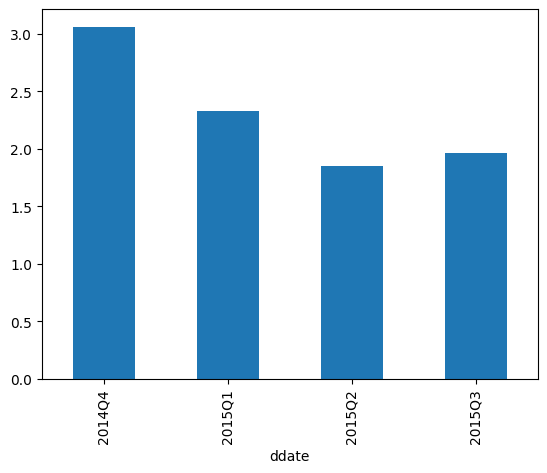

In [8]:
eps = aapl_nums[
    (aapl_nums.tag == "EarningsPerShareDiluted") & (aapl_nums.qtrs == 1)
].drop("tag", axis=1)
eps = eps.groupby("adsh").apply(
    lambda x: x.nlargest(n=1, columns=["ddate"]), include_groups=False
)
eps = eps[["ddate", "value"]].set_index("ddate").squeeze().sort_index()
ax = eps.plot.bar()
ax.set_xticklabels(eps.index.to_period("Q"));

C:\Users\bw200\AppData\Local\pypoetry\Cache\virtualenvs\py-quant-news-playground-0ZE7DJk8-py3.11\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Text(0.5, 1.0, 'Trailing P/E')

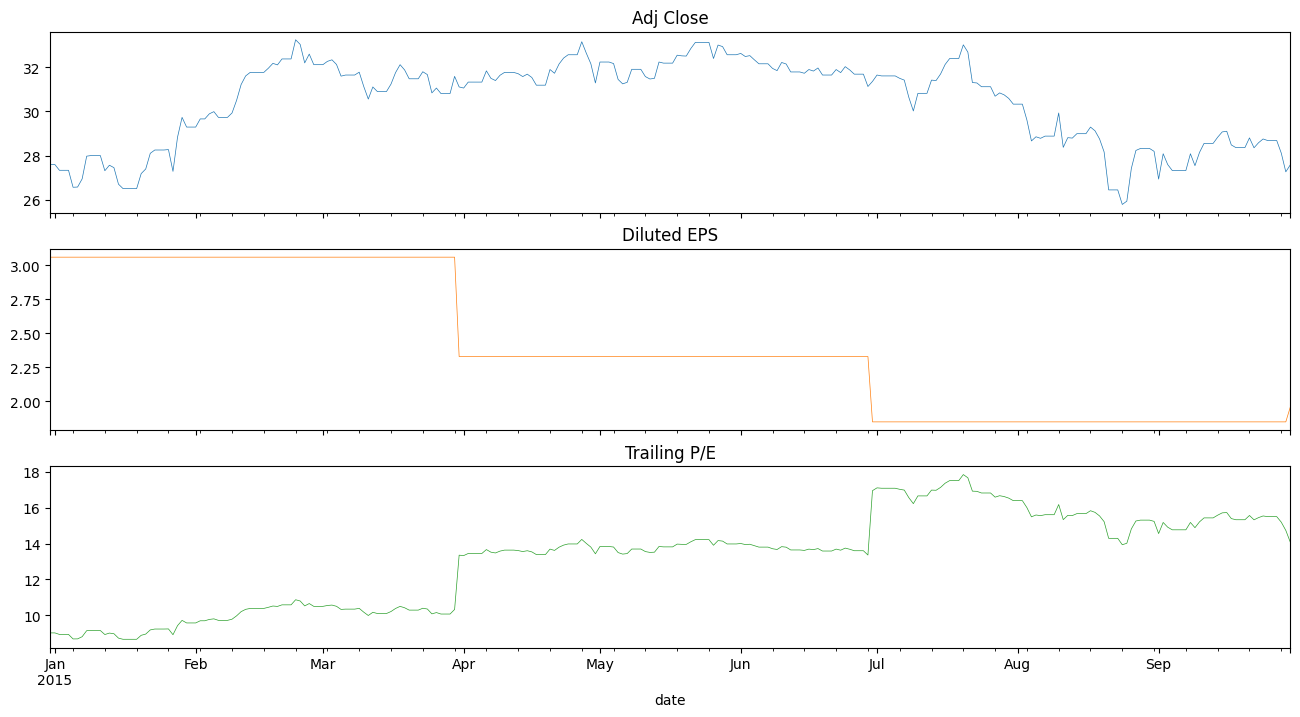

In [9]:
aapl = (
    obb.equity.price.historical(
        "AAPL", start_date="2014-12-31", end_date=eps.index.max(), provider="yfinance"
    )
    .to_df()
    .resample("D")
    .last()
    .loc["2014":"2015"]
)

pe = aapl.close.to_frame("price").join(eps.to_frame("eps")).ffill().dropna()
pe["pe_ratio"] = pe.price.div(pe.eps)
ax = pe.plot(subplots=True, figsize=(16, 8), legend=False, lw=0.5)
ax[0].set_title("Adj Close")
ax[1].set_title("Diluted EPS")
ax[2].set_title("Trailing P/E")